# Basic Production Planning Problem

The scheduler for a specialty chemical manufacturing company wants to set up next week's loading schedule.

The manufacturing process is very simple as it includes a single product formulation stage,
where the base material is mixed with different additives, depending on the customer's specifications.

To achieve higher production capacity, four mixing equipment (“mixers”) operate in parallel in
the single processing stage. At a given moment, each piece of equipment may be processing a different product.

There are 6 different products with their respective demand.

| Product | Demand |
| ------- | ------ |
| P1      | 18     |
| P2      | 16     |
| P3      | 20     |
| P4      | 15     |
| P5      | 13     |
| P6      | 17     |

Each of the 4 mixers has it's own capacity.

| Mixer | Capacity |
| ----- | -------- |
| E1    | 8        |
| E2    | 6        |
| E3    | 4        |
| E4    | 3        |

Processing time of each product in each mixer.

| Product | E1  | E1  | E1  | E1  |
| ------- | --- | --- | --- | --- |
| P1      | 14  | 12  | 10  | 10  |
| P2      | 16  | 15  | 14  | 12  |
| P3      | 20  | 16  | 14  | 12  |
| P4      | 10  | 9   | 7   | 6   |
| P5      | 25  | 21  | 20  | 18  |
| P6      | 20  | 17  | 16  | 10  |

- Mixers working at full capacity
- Demand must be satisfied exactly
- It is not possible to manufacture more than 4 batches of a product in a single mixer

The objective is to determine how many batches to make of each product in each piece
of equipment to satisfy the demand so that the equipment is vacated as soon as possible


In [25]:
import pandas as pd
import pyomo.environ as pyo
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Create Sets of Products and Mixers
P = [f"P{i}" for i in range(1, 7)]
E = [f"E{i}" for i in range(1, 5)]

In [3]:
# Demand of each product
dem = {
    "P1": 18,
    "P2": 16,
    "P3": 20,
    "P4": 15,
    "P5": 13,
    "P6": 17,
}

# Capacity of each mixer
cap = {
    "E1": 8,
    "E2": 6,
    "E3": 4,
    "E4": 3,
}

# Processing time of each product in each mixer.
tp = {
    ("P1", "E1"): 14,
    ("P1", "E2"): 12,
    ("P1", "E3"): 10,
    ("P1", "E4"): 10,
    ("P2", "E1"): 16,
    ("P2", "E2"): 15,
    ("P2", "E3"): 14,
    ("P2", "E4"): 12,
    ("P3", "E1"): 20,
    ("P3", "E2"): 16,
    ("P3", "E3"): 14,
    ("P3", "E4"): 12,
    ("P4", "E1"): 10,
    ("P4", "E2"): 9,
    ("P4", "E3"): 7,
    ("P4", "E4"): 6,
    ("P5", "E1"): 25,
    ("P5", "E2"): 21,
    ("P5", "E3"): 20,
    ("P5", "E4"): 18,
    ("P6", "E1"): 20,
    ("P6", "E2"): 17,
    ("P6", "E3"): 16,
    ("P6", "E4"): 10,
}

In [4]:
m = pyo.ConcreteModel()

# SETS
m.P = pyo.Set(initialize=P)
m.E = pyo.Set(initialize=E)

# VARIABLES
m.X = pyo.Var(m.P, m.E, domain=pyo.NonNegativeIntegers, initialize=0)
m.H = pyo.Var(m.E, domain=pyo.NonNegativeReals, initialize=0)
m.MK = pyo.Var(domain=pyo.NonNegativeReals, initialize=0)


# PARAMETERS (optional)
m.dem = pyo.Param(m.P, initialize=dem, domain=pyo.Integers)
m.cap = pyo.Param(m.E, initialize=cap, domain=pyo.Integers)
m.tp = pyo.Param(m.P, m.E, initialize=tp)


# CONSTRAINTS
def c_demand(m, p):
    return sum(m.X[p, e] * m.cap[e] for e in m.E) == m.dem[p]


m.c_demand = pyo.Constraint(m.P, rule=c_demand)


def c_production_times(m, e):
    return sum(m.X[p, e] * m.tp[p, e] for p in m.P) == m.H[e]


m.c_production_times = pyo.Constraint(m.E, rule=c_production_times)


def c_max_batchs(m, p, e):
    return m.X[p, e] <= 4


m.c_max_batchs = pyo.Constraint(m.P, m.E, rule=c_max_batchs)


def c_makespan(m, e):
    return m.H[e] <= m.MK


m.c_makespan = pyo.Constraint(m.E, rule=c_makespan)


def OBJ(m):
    return m.MK


m.OBJ = pyo.Objective(rule=OBJ, sense=pyo.minimize)

In [5]:
# pyo.SolverFactory("glpk").solve(m).write()
pyo.SolverFactory("cbc").solve(m).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 72.0
  Upper bound: 72.0
  Number of objectives: 1
  Number of constraints: 10
  Number of variables: 25
  Number of binary variables: 0
  Number of integer variables: 24
  Number of nonzeros: 1
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.15
  Wallclock time: 0.22
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
 

In [6]:
print("Optimal MakeSpan: ", m.MK.value)

Optimal MakeSpan:  72.0


In [7]:
prod_plan = []
for var in m.X.values():
    if var.value:
        if var.value > 0:
            prod_plan.append([var.index()[0], var.index()[1], var.value])

In [8]:
prod_plan_df = pd.DataFrame(prod_plan, columns=["Product", "Mixer", "Batches"])

prod_plan_df.pivot(index="Product", columns="Mixer")

Batches               
Mixer        E1   E2   E3   E4
Product                       
P1          NaN  1.0  3.0  NaN
P2          2.0  NaN  NaN  NaN
P3          1.0  1.0  NaN  2.0
P4          NaN  NaN  3.0  1.0
P5          NaN  1.0  1.0  1.0
P6          1.0  1.0  NaN  1.0

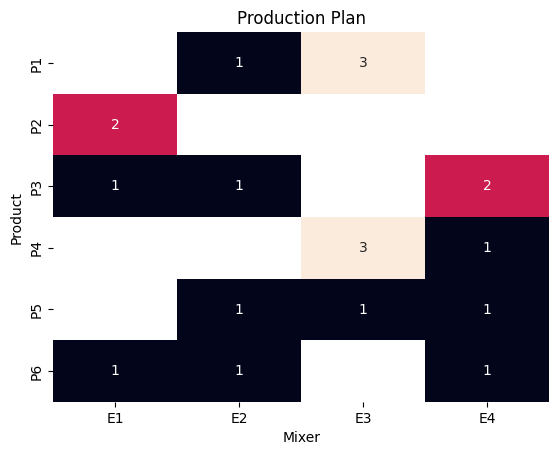

In [26]:
prod_plan_matrix = prod_plan_df.pivot(index="Product", columns="Mixer").droplevel(0, 1)
sns.heatmap(prod_plan_matrix, annot=True, cbar=False, cmap="rocket").set(
    title="Production Plan"
)
plt.savefig("../images/production-plan-matrix.png")

Based on the capacity of each Mixer and the number of batches we can compute the total amount of products


In [11]:
prod_plan_df = pd.DataFrame(prod_plan, columns=["Product", "Mixer", "Batches"])

prod_plan_df = prod_plan_df.merge(
    pd.DataFrame.from_dict(cap, orient="index", columns=["Capacity"])
    .reset_index()
    .rename(columns={"index": "Mixer"}),
    left_on=["Mixer"],
    right_on=["Mixer"],
).assign(Quantity=lambda df: df["Capacity"] * df["Batches"])
prod_plan_df

,Product,Mixer,Batches,Capacity,Quantity
0,P1,E2,2.0,6,12.0
1,P4,E2,1.0,6,6.0
2,P5,E2,1.0,6,6.0
3,P6,E2,1.0,6,6.0
4,P1,E4,2.0,3,6.0
5,P4,E4,3.0,3,9.0
6,P5,E4,1.0,3,3.0
7,P6,E4,1.0,3,3.0
8,P2,E1,2.0,8,16.0
9,P3,E1,2.0,8,16.0


Lastly, we can manually check that the demand of each product is satisfied correctly.


In [12]:
prod_plan_df.groupby("Product").agg({"Quantity": "sum"}).reset_index().merge(
    pd.DataFrame.from_dict(dem, orient="index", columns=["Demand"])
    .reset_index()
    .rename(columns={"index": "Product"}),
    left_on=["Product"],
    right_on=["Product"],
)

,Product,Quantity,Demand
0,P1,18.0,18
1,P2,16.0,16
2,P3,20.0,20
3,P4,15.0,15
4,P5,13.0,13
5,P6,17.0,17
